<div style="border: 2px solid red; padding: 10px; border-radius: 5px;">
<strong>Notebook description:</strong>
    
This notebook plots RNAseq misc. results

<strong>Input Data:</strong>

`featurecount.sh` outputs

`counts.txt`

`abca7_rna_seq_metadata_with_seqIDs.csv`

<strong>Figures:</strong>

`Fig3`
`Fig4`
`ED10`
`ED11`
`ED12`

<strong>Last Run All:</strong>
June 17, 2025




In [1]:
# load packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib.lines import Line2D
from matplotlib import patches
from matplotlib.lines import Line2D

import stack_data  # Adjust this to your module's data-loading function


In [2]:
import matplotlib as mpl
mpl.rcParams.update({
    'font.size':        12,   # default text size
    'axes.labelsize':   14,   # x/y label size
    'xtick.labelsize':  12,   # tick label size
    'ytick.labelsize':  12,
    'legend.fontsize':  12,
    'axes.titlesize':   16,
})

In [3]:
sns.set_theme(style="white", context="talk")
import matplotlib as mpl
# For PDF output:
mpl.rcParams['pdf.fonttype'] = 42      # 42 = TrueType (editable)
# For SVG output:
mpl.rcParams['svg.fonttype'] = 'none' 

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica', 'Arial']

Load data

In [4]:
# load data
counts = pd.read_csv('../../bulkRNAseq/counts.txt', delimiter='\t', comment="#")
metadata = pd.read_csv('../../bulkRNAseq/abca7_rna_seq_metadata_with_seqIDs.csv')
metadata['SeqID'] = metadata['SeqID'].str.strip()
metadata[(metadata['Notes'].str.contains('batch 1')) & (metadata['Treatment']=='H20')]['Line'].value_counts()

# get counts
sam_columns = [col for col in counts.columns if col.endswith('.sam')]
counts_extracted = counts[sam_columns]
new_column_names = {col: col.split('_')[1].split('Aligned')[0] for col in counts_extracted.columns}
counts_extracted.rename(columns=new_column_names, inplace=True)
counts_sums = counts_extracted.sum(axis=0)
counts_cpm = counts_extracted.div(counts_sums, axis=1) * 1e6 

# subset to protein coding
names = set(counts['gene_name'][counts['gene_type']=='protein_coding'])
index = counts['gene_type']=='protein_coding'
counts_cpm_protein_coding = counts_cpm[index]
counts_cpm_protein_coding.index = counts['gene_name'][index]
counts_cpm_protein_coding = counts_cpm_protein_coding.iloc[:, 1:]

# load DEGs
data1 = pd.read_csv('../../bulkRNAseq/y622_degs.csv', index_col=0)
data2 = pd.read_csv('../../bulkRNAseq/choline_degs.csv', index_col=0)
data3 = pd.read_csv('../../bulkRNAseq/g2_degs.csv', index_col=0)
data4 = pd.read_csv('../../bulkRNAseq/choline_batch2_degs.csv', index_col=0)

data1.head()
data2.head()
data1.index = data1['genes']
data2.index = data2['genes']
data3.index = data3['genes']
data4.index = data4['genes']
data1['score'] = -np.log10(data1['P.Value']) * np.sign(data1['logFC'])
data2['score'] = -np.log10(data2['P.Value']) * np.sign(data2['logFC'])
data3['score'] = -np.log10(data3['P.Value']) * np.sign(data3['logFC'])
data4['score'] = -np.log10(data4['P.Value']) * np.sign(data4['logFC'])


/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_77360/2678165156.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counts_extracted.rename(columns=new_column_names, inplace=True)


Main correlation both lines

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


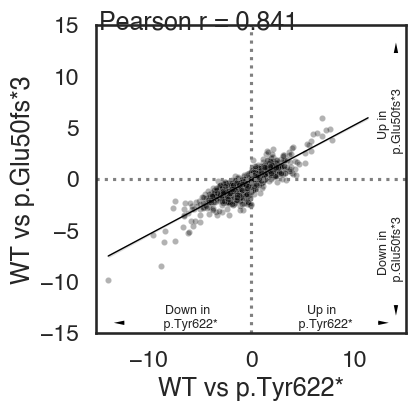

In [5]:
# show correlation of scores between the two LoF lines

data_merged = pd.merge(data1, data3, left_index=True, right_index=True)


plt.figure(figsize=(4, 4))

# Create a random subsample (e.g., 10% of the points)
sample_df = data_merged.sample(frac=0.2, random_state=42)

# Plot the regression line using the full dataset without scatter points
sns.regplot(x='score_x', y='score_y', data=data_merged, scatter=False, ci=95, color='black', line_kws={'linewidth': 1})

# Overlay scatter points from the subsample
sns.scatterplot(x='score_x', y='score_y', data=sample_df, color='black', alpha=0.3, s=20)

# Calculate Pearson correlation coefficient and p-value
r, p = stats.pearsonr(data_merged['score_x'], data_merged['score_y'])

# Add text annotation with the correlation coefficient
plt.text(0.01, 1.05, f'Pearson r = {r:.3f}',
         transform=plt.gca().transAxes, verticalalignment='top')

# Add horizontal and vertical dotted lines at zero
plt.axhline(y=0, color='grey', linestyle='dotted')
plt.axvline(x=0, color='grey', linestyle='dotted')

plt.xlabel('WT vs p.Tyr622*')
plt.ylabel('WT vs p.Glu50fs*3')
# Add arrow in lower right quadrant
plt.annotate('', xy=(14, -14), xytext=(10, -14),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(7, -14.5, 'Up in \n p.Tyr622*', ha='center', fontsize=9)

plt.annotate('', xy=(-14, -14), xytext=(-10, -14),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(-6, -14.5, 'Down in \n p.Tyr622*', ha='center', fontsize=9)

plt.annotate('', xy=(14, 14), xytext=(14, 10),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(13.5, 2.5, 'Up in \n p.Glu50fs*3', ha='center', fontsize=9, rotation=90)

plt.annotate('', xy=(14, -14), xytext=(14, -10),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(13.5, -10, 'Down in \n p.Glu50fs*3', ha='center', fontsize=9, rotation=90)


plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.savefig('../../editorial_paper/main_panels_svgs/fig3/rna_correlation_both_lof_lines.pdf', bbox_inches='tight')

plt.show()


Main correlation + Treatment

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


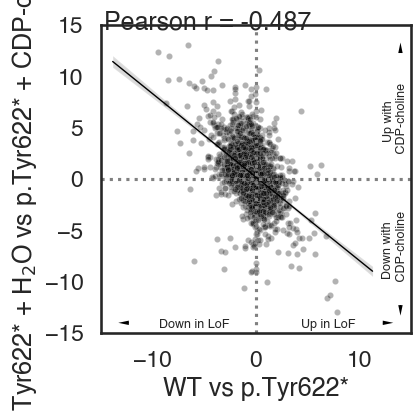

In [6]:
# show correlation of scores between CDP-choline and LoF

data_merged = pd.merge(data1, data2, left_index=True, right_index=True)

plt.figure(figsize=(4, 4))

# Create a random subsample (e.g., 10% of the points)
sample_df = data_merged.sample(frac=0.2, random_state=42)

# Plot the regression line using the full dataset without scatter points
sns.regplot(x='score_x', y='score_y', data=data_merged, scatter=False, ci=95, color='black', line_kws={'linewidth': 1})

# Overlay scatter points from the subsample
sns.scatterplot(x='score_x', y='score_y', data=sample_df, color='black', alpha=0.3, s=20)

# Calculate Pearson correlation coefficient and p-value
r, p = stats.pearsonr(data_merged['score_x'], data_merged['score_y'])

# Add text annotation with the correlation coefficient
plt.text(0.01, 1.05, f'Pearson r = {r:.3f}',
         transform=plt.gca().transAxes, verticalalignment='top')

# Add horizontal and vertical dotted lines at zero
plt.axhline(y=0, color='grey', linestyle='dotted')
plt.axvline(x=0, color='grey', linestyle='dotted')

plt.xlabel('WT vs p.Tyr622*')
plt.ylabel('p.Tyr622* + H$_2$O vs p.Tyr622* + CDP-choline')
# Add arrow in lower right quadrant
plt.annotate('', xy=(14, -14), xytext=(10, -14),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(7, -14.5, 'Up in LoF', ha='center', fontsize=9)

plt.annotate('', xy=(-14, -14), xytext=(-10, -14),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(-6, -14.5, 'Down in LoF', ha='center', fontsize=9)

plt.annotate('', xy=(14, 14), xytext=(14, 10),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(13.5, 2.5, 'Up with \n CDP-choline', ha='center', fontsize=9, rotation=90)

plt.annotate('', xy=(14, -14), xytext=(14, -10),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(13.5, -10, 'Down with \n CDP-choline', ha='center', fontsize=9, rotation=90)


plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.savefig('../../editorial_paper/main_panels_svgs/fig4/rna_correlation_plot.pdf', bbox_inches='tight')

plt.show()


Plot UCP2

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_77360/1986113202.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['UCP2', 'UCP2'])
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


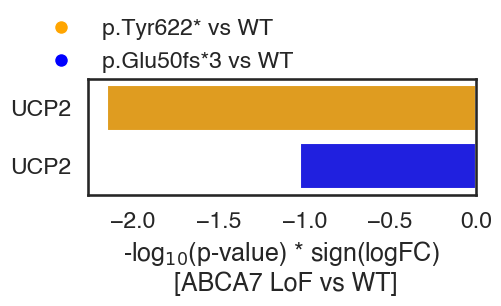

In [7]:

temp1 = pd.DataFrame(data1.loc['UCP2'])
temp1['grp'] = 'p.Tyr622* vs WT'
temp2 = pd.DataFrame(data3.loc['UCP2'])
temp2['grp'] = 'p.Glu50fs*3 vs WT'

df = pd.concat([temp1, temp2], axis=0)
df = df.loc['score']

plt.figure(figsize=(5, 1.5))

ax = sns.barplot(x='UCP2', y='grp', data=df, hue='grp',  palette={'p.Tyr622* vs WT': 'orange', 'p.Glu50fs*3 vs WT': 'blue'}, dodge=False)

plt.ylabel('')
plt.title('')
plt.yticks(fontstyle='italic')

ax.set_yticklabels(['UCP2', 'UCP2'])


legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor='orange', markersize=10, label='p.Tyr622* vs WT'),
    Line2D([0], [0], marker='o', markerfacecolor='blue', color='w',
           markersize=10, linestyle='None', label='p.Glu50fs*3 vs WT')
]
plt.legend(handles=legend_elements, title='', bbox_to_anchor=(0.2, 1.7), loc='upper center', frameon=False)
plt.xlabel('-log$_{10}$(p-value) * sign(logFC) \n [ABCA7 LoF vs WT]')
plt.savefig('../../editorial_paper/main_panels_svgs/ed10/UCP_levels.pdf', dpi=300, bbox_inches='tight')


PCA Treatment

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


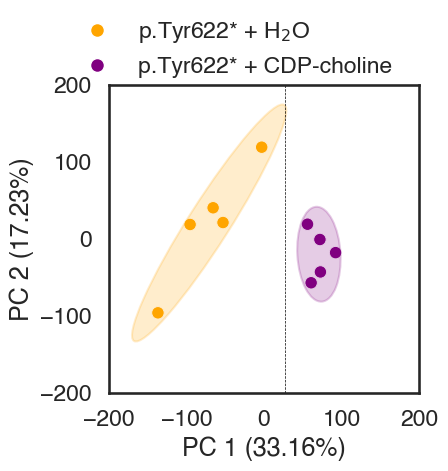

In [8]:
# show PCA; treatment batch 1
batch_1_seqids = metadata[metadata['Notes'].str.contains('batch 1')]['SeqID']
line_seqids = metadata[metadata['Line'] == 'Y622']['SeqID']
counts_cpm_protein_coding_batch_1 = counts_cpm_protein_coding[np.intersect1d(batch_1_seqids, line_seqids)]

# Perform PCA on the counts_cpm_protein_coding
scaler = StandardScaler()
counts_cpm_protein_coding_scaled = scaler.fit_transform(counts_cpm_protein_coding_batch_1.T)
pca = PCA(n_components=4)
principal_components = pca.fit_transform(counts_cpm_protein_coding_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_df['SeqID'] = counts_cpm_protein_coding_batch_1.columns
pca_df = pd.merge(pca_df, metadata, on='SeqID')

pca_df['grp'] = pca_df['Treatment'] + '_' + pca_df['Line']
# plot results
plt.figure(figsize=(4, 4))
sns.scatterplot(x='PC1', y='PC2', hue='grp', data=pca_df, palette={'H20_Control': 'grey', 'H20_Y622': 'orange', 'Choline2Weeks_Y622': 'purple'}, edgecolor='w')

pca_df['grp'] = pca_df['Treatment'] + '_' + pca_df['Line']
#Add confidence ellipses for each group
for treatment in pca_df['grp'].unique():
    line_data = pca_df[pca_df['grp'] == treatment]
    confidence_ellipse = np.cov(line_data['PC1'], line_data['PC2'])
    eigenvals, eigenvecs = np.linalg.eig(confidence_ellipse)
    angle = np.degrees(np.arctan2(eigenvecs[1,0], eigenvecs[0,0]))
    
    ellipse = patches.Ellipse(xy=(line_data['PC1'].mean(), line_data['PC2'].mean()),
                            width=2*np.sqrt(eigenvals[0])*2,
                            height=2*np.sqrt(eigenvals[1])*2,
                            angle=angle,
                            fill=True,
                            alpha=0.2,
                            color='orange' if treatment=='H20_Y622' else 'purple')
    plt.gca().add_patch(ellipse)

explained_variance = pca.explained_variance_ratio_
plt.xlabel(f'PC 1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'PC 2 ({explained_variance[1]*100:.2f}%)')
plt.legend(title='Line', bbox_to_anchor=(1.05, 1), loc='upper left')
# Remove the existing legend
plt.legend([],[], frameon=False)

# Add a custom legend based on marker type


legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor='orange', markersize=10,linestyle='None', label=r'p.Tyr622* + H$_2$O'),
    Line2D([0], [0], marker='o', markerfacecolor='purple',color='w',
           markersize=10, linestyle='None', label='p.Tyr622* + CDP-choline')
]
plt.legend(handles=legend_elements, title='', bbox_to_anchor=(.4, 1.28), loc='upper center', frameon=False)
# Add vertical line along the mean of PC1
mean_pc1 = pca_df['PC1'].median()
plt.axvline(x=mean_pc1, color='black', linestyle='--',  linewidth=0.5)
plt.xlim(-200, 200)
plt.ylim(-200, 200)

plt.savefig('../../editorial_paper/main_panels_svgs/ed12/pca_rna_batch1.pdf', dpi=300, bbox_inches='tight')
plt.show()

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


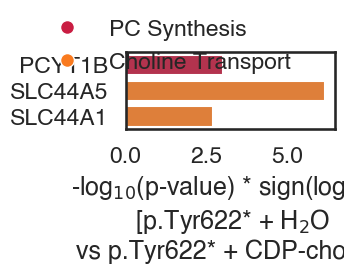

In [9]:
# Show some choline - related genes of interest 
from matplotlib.lines import Line2D

# Define lists of genes in each category
phospholipid_genes = [
    'CHKA', 'CHKB', 'PCYT1A', 'PCYT1B', 
    'CHPT1', 'CEPT1', 'PEMT', 
    'LPCAT1', 'LPCAT2', 'LPCAT3', 'LPCAT4'
]

phospholipid_genes = ['PCYT1B']

choline_transporter_genes = [
    'SLC44A2', 'SLC44A1', 'SLC44A3', 'SLC44A5'
]

fatty_acid_genes = [
    'SCD', 'SCD5', 'FADS1', 'FADS2', 'FADS3', 
    'ELOVL2', 'ELOVL5', 'ACSL'
]

# Create an empty dictionary to store the mapping
gene_to_category = {}

# Map each gene to its category
for gene in phospholipid_genes:
    gene_to_category[gene] = 'Phospholipid Synthesis/Remodeling'

for gene in choline_transporter_genes:
    gene_to_category[gene] = 'Choline Transport'

for gene in fatty_acid_genes:
    gene_to_category[gene] = 'Fatty Acid Metabolism'

genes = list(gene_to_category.keys())
y = data2.loc[np.array(genes)[[g in data2.index for g in genes]]]
y['category'] = y['genes'].map(gene_to_category)
y = y[y['adj.P.Val']<0.05]

y=y[y['category']!='Fatty Acid Metabolism']

plt.figure(figsize=(2.7, 1))
ax = sns.barplot(y='genes', x='score', data=y[['genes', 'score', 'category']].sort_values(['category', 'score'], ascending=[False, False]), width = .8, hue='category', 
            palette={'Choline Transport': '#F97A1F', 'Fatty Acid Metabolism': '#F97A1F', 'Phospholipid Synthesis/Remodeling': '#C91D42'}, dodge=False)

plt.ylabel('')
plt.title('')
plt.yticks(fontstyle='italic')


legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor='#C91D42', markersize=10, label='PC Synthesis'),
    Line2D([0], [0], marker='o', markerfacecolor='#F97A1F', color='w',
           markersize=10, linestyle='None', label='Choline Transport')
]
plt.legend(handles=legend_elements, title='', bbox_to_anchor=(0.2, 1.7), loc='upper center', frameon=False)
plt.xlabel('-log$_{10}$(p-value) * sign(logFC) \n [p.Tyr622* + H$_2$O \n vs p.Tyr622* + CDP-choline]')

plt.savefig('../../editorial_paper/main_panels_svgs/ed12/choline_synth_genes.pdf', dpi=300, bbox_inches='tight')
plt.show()



Show LPCATs

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


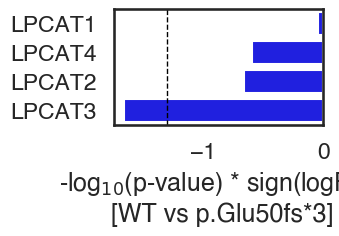

In [10]:
from matplotlib.lines import Line2D

y = data3.loc[data3.index.str.startswith('LPCAT')]

plt.figure(figsize=(2.7, 1.5))
ax = sns.barplot(y='genes', x='score', data=y[['genes', 'score']].sort_values(['score'], ascending=[False]), width = .8, dodge=False, color='blue')

plt.ylabel('')
plt.title('')
plt.yticks(fontstyle='italic')


legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor='#36E2BD', markersize=10, label='Unsaturated Fatty Acid Metabolism'),
    
]

plt.xlabel('-log$_{10}$(p-value) * sign(logFC) \n [WT vs p.Glu50fs*3]')
# Add a vertical line at x=0
plt.axvline(x=-1.3, color='black', linestyle='--', linewidth=1)

plt.savefig('../../editorial_paper/main_panels_svgs/ed11/g2_lpcat.pdf', dpi=300, bbox_inches='tight')
plt.show()



1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


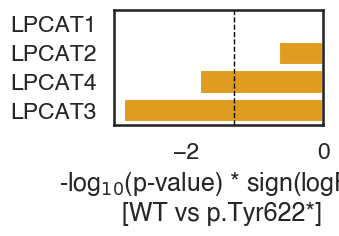

In [11]:
# show desaturase genes 
from matplotlib.lines import Line2D

y = data1.loc[data1.index.str.startswith('LPCAT')]

plt.figure(figsize=(2.7, 1.5))
ax = sns.barplot(y='genes', x='score', data=y[['genes', 'score']].sort_values(['score'], ascending=[False]), width = .8, dodge=False, color='orange')

plt.ylabel('')
plt.title('')
plt.yticks(fontstyle='italic')


plt.xlabel('-log$_{10}$(p-value) * sign(logFC) \n [WT vs p.Tyr622*]')
# Add a vertical line at x=0
plt.axvline(x=-1.3, color='black', linestyle='--', linewidth=1)

plt.savefig('../../editorial_paper/main_panels_svgs/ed11/y622_lpcat.pdf', dpi=300, bbox_inches='tight')
plt.show()



1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


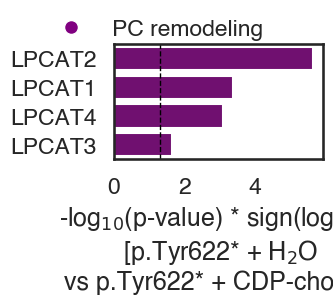

In [12]:
# show desaturase genes 
from matplotlib.lines import Line2D

y = data2.loc[data2.index.str.startswith('LPCAT')]

plt.figure(figsize=(2.7, 1.5))
ax = sns.barplot(y='genes', x='score', data=y[['genes', 'score']].sort_values(['score'], ascending=[False]), width = .8, dodge=False, color='purple')

plt.ylabel('')
plt.title('')
plt.yticks(fontstyle='italic')


legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor='purple', markersize=10, label='PC remodeling'),
    
]

plt.legend(handles=legend_elements, title='', bbox_to_anchor=(0.2, 1.4), loc='upper center', frameon=False)

plt.xlabel('-log$_{10}$(p-value) * sign(logFC) \n [p.Tyr622* + H$_2$O \n vs p.Tyr622* + CDP-choline]')
# Add a vertical line at x=0
plt.axvline(x=1.3, color='black', linestyle='--', linewidth=1)

plt.savefig('../../editorial_paper/main_panels_svgs/ed12/choline_lpcat.pdf', dpi=300, bbox_inches='tight')
plt.show()



MitoCarta Genes

In [13]:
# MioCarta database
excel_file_path = '../../processed_data/Human.MitoCarta3.0.xls'
sheet_name = 'Sheet1'  # Replace with the name of the sheet you want to load
df = pd.read_excel(excel_file_path, sheet_name='A Human MitoCarta3.0')

# prepare the mito data
df['cat'] = [x.split(' |')[0].split('> ')[-1] if isinstance(x, str) else np.NaN for x in df['MitoCarta3.0_MitoPathways'].values]
dictionary = dict(zip(df['Symbol'], df['cat']))

# Subset our data
data1_mito = data1.loc[df['Symbol'][[x in set(data1.index) for x in df['Symbol']]]]
data2_mito = data2.loc[df['Symbol'][[x in set(data2.index) for x in df['Symbol']]]]
data3_mito = data3.loc[df['Symbol'][[x in set(data3.index) for x in df['Symbol']]]]

In [14]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb, to_hex
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from adjustText import adjust_text

def adjust_color(color, factor):
    """
    Adjust brightness of a color.
    factor > 1 makes the color lighter; factor < 1 makes it darker.
    """
    r, g, b = to_rgb(color)
    r = min(r * factor, 1)
    g = min(g * factor, 1)
    b = min(b * factor, 1)
    return to_hex((r, g, b))

def economist_distinct_palette(n_colors=25):
    # Define a few base colors reminiscent of The Economist style
    base_colors = [
        "#C8102E",  # bright red
        "#8C1515",  # deep red
        "#F6B600",  # gold/yellow
        "#555555",  # dark grey
        "#006E90",  # blueish
        "#008272",  # teal
        "#D4AF37",  # warm gold
        "#A7A9AC",  # light grey
        "#000000"   # black
    ]
    
    # Generate variations for each base color: original, lighter, and darker
    colors = []
    for base in base_colors:
        colors.append(base)
        colors.append(adjust_color(base, 1.3))  # lighter version
        colors.append(adjust_color(base, 0.7))  # darker version

    # Remove duplicates and select the first n_colors
    unique_colors = []
    for color in colors:
        if color not in unique_colors:
            unique_colors.append(color)
    return unique_colors[:n_colors]

# Generate the palette
palette = economist_distinct_palette(20)


/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_77360/1482730810.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1_mito[data1_mito['adj.P.Val']>0.05]['cat'] = 'other'
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_77360/1482730810.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

d

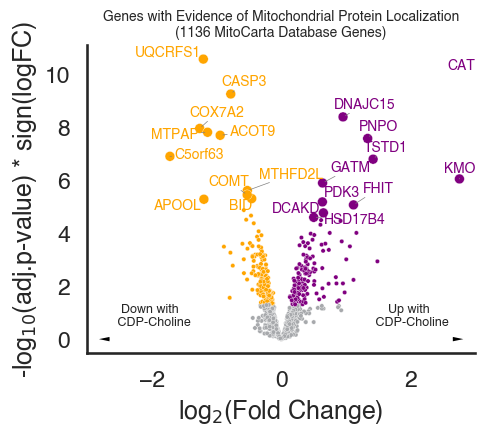

In [15]:
# prep data
data1_mito = data2.loc[df['Symbol'][[x in set(data2.index) for x in df['Symbol']]]]
#data1_mito['cat'] = data1_mito['genes'].map(dictionary)
#data1_mito['cat'][data1_mito['cat'].isna()] = 'other'
data1_mito[data1_mito['adj.P.Val']>0.05]['cat'] = 'other'

plt.figure(figsize=(5, 4))
bottom_genes = data1_mito.nsmallest(10, 'score').index
top_genes = data1_mito.nlargest(10, 'score').index
top_genes = np.concatenate([bottom_genes, top_genes])

data1_mito.loc[~data1_mito.index.isin(top_genes), 'cat'] = 'other'

# Your scatterplot
data1_mito['size'] = np.where(data1_mito.index.isin(top_genes), 50, 10)
data1_mito['cat'][(data1_mito['logFC']<0) & (data1_mito['adj.P.Val']<0.05)] = 'down'
data1_mito['cat'][(data1_mito['logFC']>0) & (data1_mito['adj.P.Val']<0.05)] = 'up'
data1_mito['cat'][data1_mito['adj.P.Val']>0.05] = 'other'
palette = {'down': 'orange', 'up': 'purple', 'other': '#A7A9AC'}
sns.scatterplot(data=data1_mito, x='logFC', y=-1*np.log10(data1_mito['adj.P.Val']), hue='cat', size='size', sizes=(10, 50), palette=palette)
# Label top genes
texts = []
for gene in top_genes:
    
    if data1_mito.loc[gene, 'adj.P.Val'] < 0.05:
        #print(gene)
        color = palette[data1_mito.loc[gene, 'cat']]
        txt = plt.text(data1_mito.loc[gene, 'logFC'],
                       -1 * np.log10(data1_mito.loc[gene, 'adj.P.Val']),
                       gene, fontsize=10, ha='right', va='bottom', style='italic', color=color)
        texts.append(txt)

# Adjust text positions to reduce overlap
plt.xlim(-3, 3)
#plt.ylim(0,6)

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))

sns.despine(top=True, right=True)
plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')
plt.legend(bbox_to_anchor=(1.25, 0.5), loc='center left')

plt.annotate('', xy=(3,0), xytext=(1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(2, .5, 'Up with \n CDP-Choline', ha='center', fontsize=9)

plt.annotate('', xy=(-3,0), xytext=(-1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(-2, .5, 'Down with \n CDP-Choline', ha='center', fontsize=9)
plt.legend().remove()
plt.title('Genes with Evidence of Mitochondrial Protein Localization\n(1136 MitoCarta Database Genes)', fontsize=10)


plt.savefig('../../editorial_paper/main_panels_svgs/fig4/choline_mito_degs.pdf', dpi=300, bbox_inches='tight')

plt.show()


/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_77360/1960118679.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1_mito[data1_mito['adj.P.Val']>0.05]['cat'] = 'other'
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_77360/1960118679.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

d

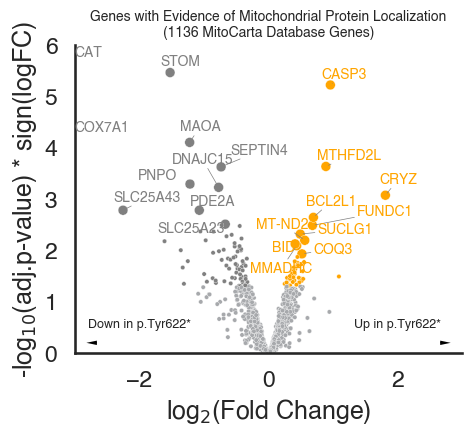

In [16]:
# prep data
data1_mito = data1.loc[df['Symbol'][[x in set(data1.index) for x in df['Symbol']]]]
#data1_mito['cat'] = data1_mito['genes'].map(dictionary)
#data1_mito['cat'][data1_mito['cat'].isna()] = 'other'
data1_mito[data1_mito['adj.P.Val']>0.05]['cat'] = 'other'

plt.figure(figsize=(5, 4))
bottom_genes = data1_mito.nsmallest(10, 'score').index
top_genes = data1_mito.nlargest(10, 'score').index
top_genes = np.concatenate([bottom_genes, top_genes])

data1_mito.loc[~data1_mito.index.isin(top_genes), 'cat'] = 'other'

# Your scatterplot
data1_mito['size'] = np.where(data1_mito.index.isin(top_genes), 50, 10)
data1_mito['cat'][(data1_mito['logFC']<0) & (data1_mito['adj.P.Val']<0.05)] = 'down'
data1_mito['cat'][(data1_mito['logFC']>0) & (data1_mito['adj.P.Val']<0.05)] = 'up'
data1_mito['cat'][data1_mito['adj.P.Val']>0.05] = 'other'
palette = {'down': 'grey', 'up': 'orange', 'other': '#A7A9AC'}
sns.scatterplot(data=data1_mito, x='logFC', y=-1*np.log10(data1_mito['adj.P.Val']), hue='cat', size='size', sizes=(10, 50), palette=palette)
# Label top genes
texts = []
for gene in top_genes:
    
    if data1_mito.loc[gene, 'adj.P.Val'] < 0.05:
        #print(gene)
        color = palette[data1_mito.loc[gene, 'cat']]
        txt = plt.text(data1_mito.loc[gene, 'logFC'],
                       -1 * np.log10(data1_mito.loc[gene, 'adj.P.Val']),
                       gene, fontsize=10, ha='right', va='bottom', style='italic', color=color)
        texts.append(txt)

# Adjust text positions to reduce overlap
plt.xlim(-3, 3)
plt.ylim(0,6)

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))

sns.despine(top=True, right=True)
plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')
plt.legend(bbox_to_anchor=(1.25, 0.5), loc='center left')

plt.annotate('', xy=(3,0.2), xytext=(1, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(2, .5, 'Up in p.Tyr622*', ha='center', fontsize=9)

plt.annotate('', xy=(-3,0.2), xytext=(-1, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(-2, .5, 'Down in p.Tyr622*', ha='center', fontsize=9)
plt.legend().remove()
plt.title('Genes with Evidence of Mitochondrial Protein Localization\n(1136 MitoCarta Database Genes)', fontsize=10)

plt.savefig('../../editorial_paper/main_panels_svgs/fig3/y622_mito_degs.pdf', dpi=300, bbox_inches='tight')

plt.show()


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


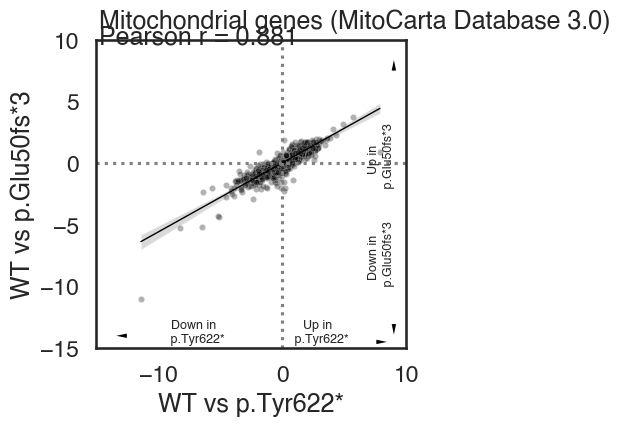

In [17]:
# Show mito correlations between the two lines 

data_merged = pd.merge(data1_mito, data3_mito, left_index=True, right_index=True)


plt.figure(figsize=(4, 4))

# Create a random subsample (e.g., 10% of the points)
sample_df = data_merged.sample(frac=1, random_state=42)

# Plot the regression line using the full dataset without scatter points
sns.regplot(x='score_x', y='score_y', data=data_merged, scatter=False, ci=95, color='black', line_kws={'linewidth': 1})

# Overlay scatter points from the subsample
sns.scatterplot(x='score_x', y='score_y', data=sample_df, color='black', alpha=0.3, s=20)

# Calculate Pearson correlation coefficient and p-value
r, p = stats.pearsonr(data_merged['score_x'], data_merged['score_y'])

# Add text annotation with the correlation coefficient
plt.text(0.01, 1.05, f'Pearson r = {r:.3f}',
         transform=plt.gca().transAxes, verticalalignment='top')

# Add horizontal and vertical dotted lines at zero
plt.axhline(y=0, color='grey', linestyle='dotted')
plt.axvline(x=0, color='grey', linestyle='dotted')

plt.xlabel('WT vs p.Tyr622*')
plt.ylabel('WT vs p.Glu50fs*3')
# Add arrow in lower right quadrant
plt.annotate('', xy=(9, 9), xytext=(9, 5),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(3, -14.5, 'Up in \n p.Tyr622*', ha='center', fontsize=9)

plt.annotate('', xy=(-14, -14), xytext=(-10, -14),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(-7, -14.5, 'Down in \n p.Tyr622*', ha='center', fontsize=9)

plt.annotate('', xy=(9, -14.5), xytext=(9, -11),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(8, -2, 'Up in \n p.Glu50fs*3', ha='center', fontsize=9, rotation=90)

plt.annotate('', xy=(9, -14.5), xytext=(6, -14.5),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(8, -10, 'Down in \n p.Glu50fs*3', ha='center', fontsize=9, rotation=90)


plt.text(0.01, 1.1, 'Mitochondrial genes (MitoCarta Database 3.0)',
         transform=plt.gca().transAxes, verticalalignment='top')


plt.xlim(-15, 10)
plt.ylim(-15, 10)
plt.savefig('../../editorial_paper/main_panels_svgs/ed9/rna_correlation_miocarta_both_lines.pdf', bbox_inches='tight')

plt.show()


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


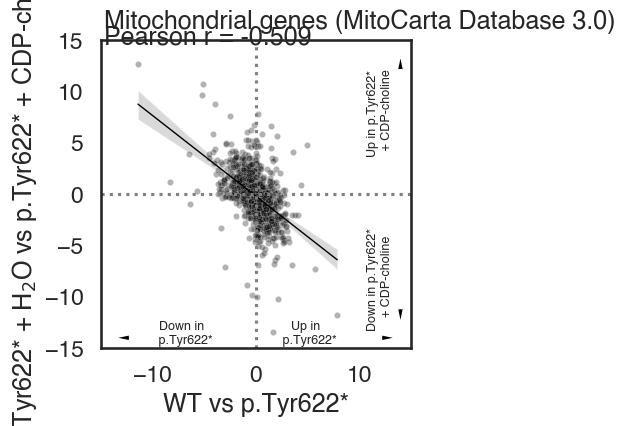

In [18]:
# show mito correlations for CDP-choline and LoF

data_merged = pd.merge(data1_mito, data2_mito, left_index=True, right_index=True)


plt.figure(figsize=(4, 4))

# Create a random subsample (e.g., 10% of the points)
sample_df = data_merged.sample(frac=1, random_state=42)

# Plot the regression line using the full dataset without scatter points
sns.regplot(x='score_x', y='score_y', data=data_merged, scatter=False, ci=95, color='black', line_kws={'linewidth': 1})

# Overlay scatter points from the subsample
sns.scatterplot(x='score_x', y='score_y', data=sample_df, color='black', alpha=0.3, s=20)

# Calculate Pearson correlation coefficient and p-value
r, p = stats.pearsonr(data_merged['score_x'], data_merged['score_y'])

# Add text annotation with the correlation coefficient
plt.text(0.01, 1.05, f'Pearson r = {r:.3f}',
         transform=plt.gca().transAxes, verticalalignment='top')

# Add horizontal and vertical dotted lines at zero
plt.axhline(y=0, color='grey', linestyle='dotted')
plt.axvline(x=0, color='grey', linestyle='dotted')

plt.xlabel('WT vs p.Tyr622*')
plt.ylabel('p.Tyr622* + H$_2$O vs p.Tyr622* + CDP-choline')
# Add arrow in lower right quadrant
plt.annotate('', xy=(14, 14), xytext=(14, 8),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(5, -14.5, 'Up in \n p.Tyr622*', ha='center', fontsize=9)

plt.annotate('', xy=(-14, -14), xytext=(-10, -14),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(-7, -14.5, 'Down in \n p.Tyr622*', ha='center', fontsize=9)

plt.annotate('', xy=(14, -13), xytext=(14, -8),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(12, 4, 'Up in p.Tyr622* \n + CDP-choline', ha='center', fontsize=9, rotation=90)

plt.annotate('', xy=(14, -14), xytext=(9, -14),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(12, -13, 'Down in p.Tyr622*\n  + CDP-choline', ha='center', fontsize=9, rotation=90)


plt.text(0.01, 1.1, 'Mitochondrial genes (MitoCarta Database 3.0)',
         transform=plt.gca().transAxes, verticalalignment='top')


plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.savefig('../../editorial_paper/main_panels_svgs/ed12/rna_correlation_miocarta_choline.pdf', bbox_inches='tight')

plt.show()


MitoCarta Pathway enrichment

In [19]:
import statsmodels.stats.multitest as smm
import gseapy as gp


# Load MioCarta Pathways
excel_file_path = '../../processed_data/Human.MitoCarta3.0.xls'
sheet_name = 'Sheet1'  # Replace with the name of the sheet you want to load
paths = pd.read_excel(excel_file_path, sheet_name='C MitoPathways')
paths = paths.dropna()
pathways = dict(zip(paths['MitoPathway'], [x.split(', ') for x in paths['Genes']]))

# characterise mito gene changes for Y622

genes_up = data1_mito[(data1_mito['adj.P.Val']<0.05) & (data1_mito['logFC']>0)]['genes'].values
genes_down = data1_mito[(data1_mito['adj.P.Val']<0.05) & (data1_mito['logFC']<0)]['genes'].values

enr = gp.enrichr(gene_list=list(genes_down),
                 gene_sets=pathways,
                 outdir='enrichr_results', cutoff=1, background=data1_mito['genes'].values)

temp = enr.results#.sort_values('P-value', ascending=True).head(10)
p_values = temp['P-value']
# Apply FDR correction (Benjamini-Hochberg method)
_, fdr_corrected_pvals, _, _ = smm.multipletests(p_values, alpha=0.05, method='fdr_bh')
temp['FDR'] = fdr_corrected_pvals

x = temp.sort_values('P-value', ascending=True)#[:10]
x = x[x['P-value']<0.05]

x['direction'] = 'down'
x['score'] = np.log10(x['P-value'])
x['sig'] = x['FDR']<0.05


enr = gp.enrichr(gene_list=list(genes_up),
                 gene_sets=pathways,
                 outdir='enrichr_results', cutoff=1, background=data1_mito['genes'].values)

temp = enr.results#.sort_values('P-value', ascending=True).head(10)
p_values = temp['P-value']
# Apply FDR correction (Benjamini-Hochberg method)
_, fdr_corrected_pvals, _, _ = smm.multipletests(p_values, alpha=0.05, method='fdr_bh')
temp['FDR'] = fdr_corrected_pvals

x2 = temp.sort_values('P-value', ascending=True)#[:10]
x2 = x2[x2['P-value']<0.05]

x2['direction'] = 'up'
x2['score'] = -np.log10(x2['P-value'])
x2['sig'] = x2['FDR']<0.05

both = pd.concat([x, x2])
both = both.sort_values('score', ascending=False)

both[['Term', 'score', 'P-value', 'FDR', 'Genes']]


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


,Term,score,P-value,FDR,Genes
1,Apoptosis,1.900274,0.012581,0.415774,CYCS;BCL2L1;BID;CASP3;BIK
43,OXPHOS,1.894438,0.012752,0.415774,COX14;COX6A1;NDUFS4;SDHAF2;ATP5PB;COA4;CYCS;MT...
51,Protein import and sorting,1.755279,0.017568,0.415774,TIMM23;SAMM50;DNAJC19;TIMM8A;TOMM22;TIMM10
45,OXPHOS subunits,1.552584,0.028017,0.477391,COX6A1;NDUFS4;ATP5PB;CYCS;ATP5MG;MT-ND2;NDUFA4...
38,Mitochondrial dynamics and surveillance,1.473414,0.033619,0.477391,SAMM50;CYCS;FUNDC1;BCL2L1;FUNDC2;BID;ATP5MG;CA...
2,Amino acid metabolism,-1.374004,0.042267,0.263353,AADAT;DLST;ABAT;SFXN3;ALDH5A1;MCCC2;COMT;SLC25...
22,Detoxification,-1.395286,0.040245,0.263353,EPHX2;CAT;CYB5R3;CYB5B;DHRS2;TXNRD2;MAOA
23,EF hand proteins,-1.441227,0.036205,0.263353,RHOT2;SLC25A25;SLC25A23
37,Lipid metabolism,-1.441792,0.036158,0.263353,GPAT2;CYP27A1;ACAD10;CPT1C;ACADVL;CROT;IDI1;SL...
1,Amidoxime reducing complex,-1.576863,0.026493,0.238440,CYB5R3;CYB5B


In [20]:
both[['Term', 'score', 'P-value', 'FDR', 'Genes']].to_latex(index=False)

'\\begin{tabular}{lrrrl}\n\\toprule\nTerm & score & P-value & FDR & Genes \\\\\n\\midrule\nApoptosis & 1.900274 & 0.012581 & 0.415774 & CYCS;BCL2L1;BID;CASP3;BIK \\\\\nOXPHOS & 1.894438 & 0.012752 & 0.415774 & COX14;COX6A1;NDUFS4;SDHAF2;ATP5PB;COA4;CYCS;MT-ND2;ATP5MG;NDUFAF2;TMEM126A;NDUFA4;NDUFA1;ATP5MC3 \\\\\nProtein import and sorting & 1.755279 & 0.017568 & 0.415774 & TIMM23;SAMM50;DNAJC19;TIMM8A;TOMM22;TIMM10 \\\\\nOXPHOS subunits & 1.552584 & 0.028017 & 0.477391 & COX6A1;NDUFS4;ATP5PB;CYCS;ATP5MG;MT-ND2;NDUFA4;NDUFA1;ATP5MC3 \\\\\nMitochondrial dynamics and surveillance & 1.473414 & 0.033619 & 0.477391 & SAMM50;CYCS;FUNDC1;BCL2L1;FUNDC2;BID;ATP5MG;CASP3;BIK \\\\\nAmino acid metabolism & -1.374004 & 0.042267 & 0.263353 & AADAT;DLST;ABAT;SFXN3;ALDH5A1;MCCC2;COMT;SLC25A44;GCAT;MAOA \\\\\nDetoxification & -1.395286 & 0.040245 & 0.263353 & EPHX2;CAT;CYB5R3;CYB5B;DHRS2;TXNRD2;MAOA \\\\\nEF hand proteins & -1.441227 & 0.036205 & 0.263353 & RHOT2;SLC25A25;SLC25A23 \\\\\nLipid metabolism 

In [21]:
# characterise mito gene changes for choline

genes_up = data2_mito[(data2_mito['adj.P.Val']<0.05) & (data2_mito['logFC']>0)]['genes'].values
genes_down = data2_mito[(data2_mito['adj.P.Val']<0.05) & (data2_mito['logFC']<0)]['genes'].values

enr = gp.enrichr(gene_list=list(genes_down),
                 gene_sets=pathways,
                 outdir='enrichr_results', cutoff=1, background=data2_mito['genes'].values)

temp = enr.results#.sort_values('P-value', ascending=True).head(10)
p_values = temp['P-value']
# Apply FDR correction (Benjamini-Hochberg method)
_, fdr_corrected_pvals, _, _ = smm.multipletests(p_values, alpha=0.05, method='fdr_bh')
temp['FDR'] = fdr_corrected_pvals

x = temp.sort_values('P-value', ascending=True)#[:10]
x = x[x['P-value']<0.05]
x['direction'] = 'down'
x['score'] = np.log10(x['P-value'])
x['sig'] = x['FDR']<0.05


enr = gp.enrichr(gene_list=list(genes_up),
                 gene_sets=pathways,
                 outdir='enrichr_results', cutoff=1, background=data2_mito['genes'].values)

temp = enr.results#.sort_values('P-value', ascending=True).head(10)
p_values = temp['P-value']
# Apply FDR correction (Benjamini-Hochberg method)
_, fdr_corrected_pvals, _, _ = smm.multipletests(p_values, alpha=0.05, method='fdr_bh')
temp['FDR'] = fdr_corrected_pvals

x2 = temp.sort_values('P-value', ascending=True)#[:10]
x2 = x2[x2['P-value']<0.05]
x2['direction'] = 'up'
x2['score'] = -np.log10(x2['P-value'])
x2['sig'] = x2['FDR']<0.05

both = pd.concat([x, x2])
both = both.sort_values('score', ascending=False)

both[['Term', 'score', 'P-value', 'FDR', 'Genes']]




1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


,Term,score,P-value,FDR,Genes
29,EF hand proteins,4.457699,3.485789e-05,0.003451,MICU3;SLC25A25;SLC25A23;SLC25A12;SLC25A24;EFHD...
79,Small molecule transport,3.256577,5.538893e-04,0.027418,SLC25A29;SLC25A25;MPV17;SLC25A1;SLC25A24;SFXN5...
12,Calcium homeostasis,3.079591,8.325479e-04,0.027474,MICU3;SLC25A25;SLC25A23;LETM1;SLC25A12;SLC25A2...
50,Metabolism,2.846777,1.423060e-03,0.033450,OAT;TST;SLC25A25;ACP6;ACADSB;FASN;SPHK2;EPHX2;...
78,Signaling,2.772263,1.689416e-03,0.033450,MICU3;SLC25A25;NLRX1;LETM1;DELE1;SLC25A24;SLC2...
82,TCA-associated,2.563737,2.730630e-03,0.045055,ME3;ACLY;D2HGDH;ME2;SLC25A1;SFXN5;PCK2
35,Fusion,2.466941,3.412393e-03,0.048261,MFN1;MIGA2;MFN2;MIGA1;OPA1
14,Carbohydrate metabolism,1.960909,1.094186e-02,0.123756,ME3;DLST;D2HGDH;ACLY;ME2;CS;DLAT;SLC25A1;SLC25...
65,Organelle contact sites,1.856642,1.391100e-02,0.123756,SPIRE1;FKBP8;MFN1;MIGA2;MFN2;VDAC1
0,ABC transporters,1.852052,1.405880e-02,0.123756,ABCB10;ABCD3;ABCD1;ABCD2


In [22]:
both[['Term', 'score', 'P-value', 'FDR', 'Genes']].to_latex(index=False)

'\\begin{tabular}{lrrrl}\n\\toprule\nTerm & score & P-value & FDR & Genes \\\\\n\\midrule\nEF hand proteins & 4.457699 & 0.000035 & 0.003451 & MICU3;SLC25A25;SLC25A23;SLC25A12;SLC25A24;EFHD1;SLC25A13;MICU2 \\\\\nSmall molecule transport & 3.256577 & 0.000554 & 0.027418 & SLC25A29;SLC25A25;MPV17;SLC25A1;SLC25A24;SFXN5;MICU2;SLC25A23;VDAC1;ABCD3;MPV17L;SLC25A22;SLC25A12;SFXN1;SLC25A13;SLC25A15;ABCB10;ABCD1;MICU3;SLC25A39;ABCD2;SLC25A43;STARD7 \\\\\nCalcium homeostasis & 3.079591 & 0.000833 & 0.027474 & MICU3;SLC25A25;SLC25A23;LETM1;SLC25A12;SLC25A24;EFHD1;SLC25A13;VDAC1;MICU2 \\\\\nMetabolism & 2.846777 & 0.001423 & 0.033450 & OAT;TST;SLC25A25;ACP6;ACADSB;FASN;SPHK2;EPHX2;MCCC2;GLYCTK;MT-CO1;GPAT2;D2HGDH;ME2;NMNAT3;CHCHD7;GATM;ALDH9A1;ABCB10;ACAD10;NADK2;NNT;KMO;GLS;FHIT;GCAT;PDSS2;STARD7;ME3;CS;SLC25A1;SLC25A24;PPM1K;GLDC;AGPAT5;TSTD1;SLC25A23;RFK;TK2;OGDH;ECI1;DLST;ALDH1B1;SLC25A29;AK3;SFXN5;NT5M;PRXL2A;OXCT1;AADAT;HSD17B4;GSR;DLAT;IDI1;SERAC1;ACSL6;PNPO;ABAT;SFXN1;SLC25A13;PCK2;SLC25A